In [ ]:
# Import all required Libraries
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8001225/pdf/diagnostics-11-00510.pdf

#Key Features:

#Decision Trees:
#builds an ensemble of decision trees
#each tree splits the data based on feature values to make predictions

#Loss Function: can work with various loss functions for different types of problems (regression, classification, ranking)

Original Features

In [ ]:
num_trials = 10 #number of times to run the model
train_size = 0.7 #the amount of the dataset used for training

# Load data from CSV
# maindata.csv needs to be in personal drive or have a shortcut added to the personal drive to be able to read it
data = pd.read_csv('/content/drive/MyDrive/Glaucoma_Project/Datasets/IGPS/maindata.csv')
# Remove any rows with blank values from the columns of these datasets
# Trials with any combination of these features should have the same number of samples
#data = data.dropna(subset=['RNFL_average', 'IOP', 'BPSYS', 'BPDYS', 'SPP', 'DPP', 'OPP', 'MPP',
#                           'HR', 'Weight', 'Near', 'Distance', 'VS_SF', 'VS_MH', 'VS_RD', 'VS_Dep', 'MD'])
data = data.dropna(subset=['cup_disk_area_ratio', 'cup_disk_vert_ratio', 'cup_disk_horiz_ratio', 'RNFL_average', 'MD'])

# Assign class labels based on the specified thresholds
def assign_class_label(value):
    if value >= 0:
        return 0
    elif -0.01 >= value >= -5.00:
        return 1
    elif -5.01 >= value >= -12.00:
        return 2
    elif -12.01 >= value >= -20.00:
        return 3
    else:
        return 4

# Create a new column to store the class labels based on the MD values
data['class_label'] = data['MD'].apply(assign_class_label)

# Select features and target
features = ['cup_disk_area_ratio', 'cup_disk_vert_ratio', 'cup_disk_horiz_ratio', 'RNFL_average']
X = data[features]
y = data['class_label']

# Print the number of total samples and samples in each class
print("Total Samples:", len(X))
print("\nSamples in each class:")
class_counts = y.value_counts().sort_index()
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples ({count/len(y)*100:.2f}%)")

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 50)
        self.layer2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        return self.layer2(x)

# Initialize lists to store results
accuracies = []

for trial in range(num_trials):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42+trial)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)

    # Use PyTorch model for feature extraction
    model = SimpleNN(input_size=len(features))
    train_features = model(X_train_tensor).detach().numpy()
    test_features = model(X_test_tensor).detach().numpy()

    # Train XGBoost model
    clf = XGBClassifier(random_state=42+trial)
    clf.fit(train_features, y_train)

    # Make predictions
    y_pred = clf.predict(test_features)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) * 100  # Convert to percentage
    accuracies.append(accuracy)

    print(f"Trial {trial+1} Accuracy: {accuracy:.2f}%")

# Print overall results
print(f"\nMean Accuracy: {np.mean(accuracies):.2f}%")
print(f"Standard Deviation: {np.std(accuracies):.2f}%")

# Print classification report for the last trial
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the number of training samples used in training
print("Total Samples:", len(X))
print(f"Training Samples: {len(X_train)} ({len(X_train)/len(X)*100:.2f}%)")
print(f"Testing Samples: {len(X_test)} ({len(X_test)/len(X)*100:.2f}%)")

Total Samples: 975

Samples in each class:
Class 0: 161 samples (16.51%)
Class 1: 547 samples (56.10%)
Class 2: 219 samples (22.46%)
Class 3: 40 samples (4.10%)
Class 4: 8 samples (0.82%)
Trial 1 Accuracy: 57.34%
Trial 2 Accuracy: 53.24%
Trial 3 Accuracy: 57.00%
Trial 4 Accuracy: 50.51%
Trial 5 Accuracy: 55.63%
Trial 6 Accuracy: 51.54%
Trial 7 Accuracy: 51.88%
Trial 8 Accuracy: 54.27%
Trial 9 Accuracy: 50.51%
Trial 10 Accuracy: 53.24%

Mean Accuracy: 53.52%
Standard Deviation: 2.38%

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.40      0.44        47
           1       0.61      0.73      0.66       163
           2       0.31      0.26      0.28        66
           3       0.33      0.07      0.12        14
           4       0.00      0.00      0.00         3

    accuracy                           0.53       293
   macro avg       0.35      0.29      0.30       293
weighted avg       0.50      0.53      0.51       293


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Chosen Features - Uneven

In [ ]:
num_trials = 10 #number of times to run the model
train_size = 0.8 #the amount of the dataset used for training

# Load data from CSV
# maindata.csv needs to be in personal drive or have a shortcut added to the personal drive to be able to read it
data = pd.read_csv('/content/drive/MyDrive/Glaucoma_Project/Datasets/IGPS/maindata.csv')
# Remove any rows with blank values from the columns of these datasets
# Trials with any combination of these features should have the same number of samples
#data = data.dropna(subset=['RNFL_average', 'IOP', 'BPSYS', 'BPDYS', 'SPP', 'DPP', 'OPP', 'MPP',
#                           'HR', 'Weight', 'Near', 'Distance', 'VS_SF', 'VS_MH', 'VS_RD', 'VS_Dep', 'MD'])
data = data.dropna(subset=['cup_disk_area_ratio', 'cup_disk_vert_ratio', 'cup_disk_horiz_ratio', 'RNFL_average','OCT_Disc_Signal_Strength', 'OCT_RNFL_Signal_Strength', 'OCT_Macular_Signal_Strength', 'MD'])

# Assign class labels based on the specified thresholds
def assign_class_label(value):
    if value >= 0:
        return 0
    elif -0.01 >= value >= -5.00:
        return 1
    elif -5.01 >= value >= -12.00:
        return 2
    elif -12.01 >= value >= -20.00:
        return 3
    else:
        return 4

# Create a new column to store the class labels based on the MD values
data['class_label'] = data['MD'].apply(assign_class_label)

# Select features and target
features = ['cup_disk_area_ratio', 'cup_disk_vert_ratio', 'cup_disk_horiz_ratio', 'RNFL_average']
X = data[features]
y = data['class_label']

# Print the number of total samples and samples in each class
print("Total Samples:", len(X))
print("\nSamples in each class:")
class_counts = y.value_counts().sort_index()
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples ({count/len(y)*100:.2f}%)")

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 50)
        self.layer2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        return self.layer2(x)

# Initialize lists to store results
accuracies = []

for trial in range(num_trials):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42+trial)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)

    # Use PyTorch model for feature extraction
    model = SimpleNN(input_size=len(features))
    train_features = model(X_train_tensor).detach().numpy()
    test_features = model(X_test_tensor).detach().numpy()

    # Train XGBoost model
    clf = XGBClassifier(random_state=42+trial)
    clf.fit(train_features, y_train)

    # Make predictions
    y_pred = clf.predict(test_features)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) * 100  # Convert to percentage
    accuracies.append(accuracy)

    print(f"Trial {trial+1} Accuracy: {accuracy:.2f}%")

# Print overall results
print(f"\nMean Accuracy: {np.mean(accuracies):.2f}%")
print(f"Standard Deviation: {np.std(accuracies):.2f}%")

# Print classification report for the last trial
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the number of training samples used in training
print("Total Samples:", len(X))
print(f"Training Samples: {len(X_train)} ({len(X_train)/len(X)*100:.2f}%)")
print(f"Testing Samples: {len(X_test)} ({len(X_test)/len(X)*100:.2f}%)")

Total Samples: 965

Samples in each class:
Class 0: 161 samples (16.68%)
Class 1: 541 samples (56.06%)
Class 2: 218 samples (22.59%)
Class 3: 37 samples (3.83%)
Class 4: 8 samples (0.83%)
Trial 1 Accuracy: 51.81%
Trial 2 Accuracy: 53.37%
Trial 3 Accuracy: 53.37%
Trial 4 Accuracy: 58.55%
Trial 5 Accuracy: 57.51%
Trial 6 Accuracy: 63.21%
Trial 7 Accuracy: 54.92%
Trial 8 Accuracy: 50.78%
Trial 9 Accuracy: 55.96%
Trial 10 Accuracy: 51.30%

Mean Accuracy: 55.08%
Standard Deviation: 3.66%

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.41      0.46        32
           1       0.57      0.72      0.64       103
           2       0.30      0.24      0.27        45
           3       0.33      0.08      0.13        12
           4       0.00      0.00      0.00         1

    accuracy                           0.51       193
   macro avg       0.35      0.29      0.30       193
weighted avg       0.49      0.51      0.49       193


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Chosen Features - Even

In [ ]:
num_trials = 10  # number of times to run the model
train_size = 0.8  # the amount of the dataset used for training
samples_per_class = 35  # number of samples to select from each class

# Load data from CSV
data = pd.read_csv('/content/drive/MyDrive/Glaucoma_Project/Datasets/IGPS/maindata.csv')

# Remove any rows with blank values from the columns of these datasets
data = data.dropna(subset=['cup_disk_area_ratio', 'cup_disk_vert_ratio', 'cup_disk_horiz_ratio', 'RNFL_average','MD'])

# Assign class labels based on the specified thresholds
def assign_class_label(value):
    if value >= 0:
        return 0
    elif -5.00 <= value < -0.01:
        return 1
    elif -12.00 <= value < -5.01:
        return 2
    else:
        return 3

# Create a new column to store the class labels based on the MD values
data['class_label'] = data['MD'].apply(assign_class_label)

# Select features and target
features = ['cup_disk_area_ratio', 'cup_disk_vert_ratio', 'cup_disk_horiz_ratio', 'RNFL_average']

# Function to create a balanced dataset without repetition
def create_balanced_dataset(data, features, target, samples_per_class):
    balanced_data = []
    for class_label in data[target].unique():
        class_data = data[data[target] == class_label]
        if len(class_data) >= samples_per_class:
            balanced_data.append(class_data.sample(samples_per_class, random_state=42))
        else:
            print(f"Warning: Class {class_label} has only {len(class_data)} samples. Using all available samples.")
            balanced_data.append(class_data)

    return pd.concat(balanced_data, ignore_index=True)

# Create balanced dataset
balanced_data = create_balanced_dataset(data, features, 'class_label', samples_per_class)

X = balanced_data[features]
y = balanced_data['class_label']

# Print the number of total samples
print("Total Samples:", len(X))
print("Samples per class:", samples_per_class)
print("Class distribution:")
print(y.value_counts().sort_index())

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 50)
        self.layer2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        return self.layer2(x)

# Initialize lists to store results
accuracies = []

for trial in range(num_trials):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, stratify=y, random_state=42+trial)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)

    # Use PyTorch model for feature extraction
    model = SimpleNN(input_size=len(features))
    train_features = model(X_train_tensor).detach().numpy()
    test_features = model(X_test_tensor).detach().numpy()

    # Train XGBoost model
    clf = XGBClassifier(random_state=42+trial)
    clf.fit(train_features, y_train)

    # Make predictions
    y_pred = clf.predict(test_features)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) * 100  # Convert to percentage
    accuracies.append(accuracy)

    print(f"Trial {trial+1} Accuracy: {accuracy:.2f}%")

    # Print the number of samples of each class in the testing set
    # print("Number of samples in each class (Testing Set):")
    # test_class_counts = y_test.value_counts().sort_index()
    # for class_label, count in test_class_counts.items():
    #     print(f"Class {class_label}: {count} samples")
    # print()

# Print overall results
print(f"\nMean Accuracy: {np.mean(accuracies):.2f}%")
print(f"Standard Deviation: {np.std(accuracies):.2f}%")

# Print classification report for the last trial
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the number of training samples used in training
print("Total Samples:", len(X))
print(f"Training Samples: {len(X_train)} ({len(X_train)/len(X)*100:.2f}%)")
print(f"Testing Samples: {len(X_test)} ({len(X_test)/len(X)*100:.2f}%)")

Total Samples: 140
Samples per class: 35
Class distribution:
class_label
0    35
1    35
2    35
3    35
Name: count, dtype: int64
Trial 1 Accuracy: 42.86%
Trial 2 Accuracy: 60.71%
Trial 3 Accuracy: 35.71%
Trial 4 Accuracy: 46.43%
Trial 5 Accuracy: 32.14%
Trial 6 Accuracy: 46.43%
Trial 7 Accuracy: 42.86%
Trial 8 Accuracy: 57.14%
Trial 9 Accuracy: 53.57%
Trial 10 Accuracy: 46.43%

Mean Accuracy: 46.43%
Standard Deviation: 8.45%

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.20      0.14      0.17         7
           2       0.33      0.29      0.31         7
           3       0.50      0.71      0.59         7

    accuracy                           0.46        28
   macro avg       0.44      0.46      0.44        28
weighted avg       0.44      0.46      0.44        28

Total Samples: 140
Training Samples: 112 (80.00%)
Testing Samples: 28 (20.00%)


Machine Signal Strength - Uneven

In [ ]:
num_trials = 10 #number of times to run the model
train_size = 0.8 #the amount of the dataset used for training

# Load data from CSV
# maindata.csv needs to be in personal drive or have a shortcut added to the personal drive to be able to read it
data = pd.read_csv('/content/drive/MyDrive/Glaucoma_Project/Datasets/IGPS/maindata.csv')
data = data.dropna(subset=['OCT_Disc_Signal_Strength', 'OCT_RNFL_Signal_Strength', 'OCT_Macular_Signal_Strength','MD'])

# Assign class labels based on the specified thresholds
def assign_class_label(value):
    if value >= 0:
        return 0
    elif -0.01 >= value >= -5.00:
        return 1
    elif -5.01 >= value >= -12.00:
        return 2
    elif -12.01 >= value >= -20.00:
        return 3
    else:
        return 4

# Create a new column to store the class labels based on the MD values
data['class_label'] = data['MD'].apply(assign_class_label)

# Select features and target
features = ['OCT_Disc_Signal_Strength', 'OCT_RNFL_Signal_Strength', 'OCT_Macular_Signal_Strength']
X = data[features]
y = data['class_label']

# Print the number of total samples and samples in each class
print("Total Samples:", len(X))
print("\nSamples in each class:")
class_counts = y.value_counts().sort_index()
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples ({count/len(y)*100:.2f}%)")

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 50)
        self.layer2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        return self.layer2(x)

# Initialize lists to store results
accuracies = []

for trial in range(num_trials):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42+trial)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)

    # Use PyTorch model for feature extraction
    model = SimpleNN(input_size=len(features))
    train_features = model(X_train_tensor).detach().numpy()
    test_features = model(X_test_tensor).detach().numpy()

    # Train XGBoost model
    clf = XGBClassifier(random_state=42+trial)
    clf.fit(train_features, y_train)

    # Make predictions
    y_pred = clf.predict(test_features)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) * 100  # Convert to percentage
    accuracies.append(accuracy)

    print(f"Trial {trial+1} Accuracy: {accuracy:.2f}%")

# Print overall results
print(f"\nMean Accuracy: {np.mean(accuracies):.2f}%")
print(f"Standard Deviation: {np.std(accuracies):.2f}%")

# Print classification report for the last trial
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the number of training samples used in training
print("Total Samples:", len(X))
print(f"Training Samples: {len(X_train)} ({len(X_train)/len(X)*100:.2f}%)")
print(f"Testing Samples: {len(X_test)} ({len(X_test)/len(X)*100:.2f}%)")

Total Samples: 965

Samples in each class:
Class 0: 161 samples (16.68%)
Class 1: 541 samples (56.06%)
Class 2: 218 samples (22.59%)
Class 3: 37 samples (3.83%)
Class 4: 8 samples (0.83%)
Trial 1 Accuracy: 50.78%
Trial 2 Accuracy: 53.37%
Trial 3 Accuracy: 45.08%
Trial 4 Accuracy: 51.81%
Trial 5 Accuracy: 52.33%
Trial 6 Accuracy: 54.40%
Trial 7 Accuracy: 56.48%
Trial 8 Accuracy: 48.70%
Trial 9 Accuracy: 51.30%
Trial 10 Accuracy: 50.78%

Mean Accuracy: 51.50%
Standard Deviation: 2.96%

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.09      0.16        32
           1       0.55      0.86      0.67       103
           2       0.23      0.13      0.17        45
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         1

    accuracy                           0.51       193
   macro avg       0.26      0.22      0.20       193
weighted avg       0.43      0.51      0.43       193


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Machine Signal Strength - Even

In [ ]:
num_trials = 10  # number of times to run the model
train_size = 0.8  # the amount of the dataset used for training
samples_per_class = 35  # number of samples to select from each class

# Load data from CSV
data = pd.read_csv('/content/drive/MyDrive/Glaucoma_Project/Datasets/IGPS/maindata.csv')

# Remove any rows with blank values from the columns of these datasets
data = data.dropna(subset=['OCT_Disc_Signal_Strength', 'OCT_RNFL_Signal_Strength', 'OCT_Macular_Signal_Strength','MD'])

# Assign class labels based on the specified thresholds
def assign_class_label(value):
    if value >= 0:
        return 0
    elif -5.00 <= value < -0.01:
        return 1
    elif -12.00 <= value < -5.01:
        return 2
    else:
        return 3

# Create a new column to store the class labels based on the MD values
data['class_label'] = data['MD'].apply(assign_class_label)

# Select features and target
features = ['OCT_Disc_Signal_Strength', 'OCT_RNFL_Signal_Strength', 'OCT_Macular_Signal_Strength']

# Function to create a balanced dataset without repetition
def create_balanced_dataset(data, features, target, samples_per_class):
    balanced_data = []
    for class_label in data[target].unique():
        class_data = data[data[target] == class_label]
        if len(class_data) >= samples_per_class:
            balanced_data.append(class_data.sample(samples_per_class, random_state=42))
        else:
            print(f"Warning: Class {class_label} has only {len(class_data)} samples. Using all available samples.")
            balanced_data.append(class_data)

    return pd.concat(balanced_data, ignore_index=True)

# Create balanced dataset
balanced_data = create_balanced_dataset(data, features, 'class_label', samples_per_class)

X = balanced_data[features]
y = balanced_data['class_label']

# Print the number of total samples
print("Total Samples:", len(X))
print("Samples per class:", samples_per_class)
print("Class distribution:")
print(y.value_counts().sort_index())

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 50)
        self.layer2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        return self.layer2(x)

# Initialize lists to store results
accuracies = []

for trial in range(num_trials):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, stratify=y, random_state=42+trial)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)

    # Use PyTorch model for feature extraction
    model = SimpleNN(input_size=len(features))
    train_features = model(X_train_tensor).detach().numpy()
    test_features = model(X_test_tensor).detach().numpy()

    # Train XGBoost model
    clf = XGBClassifier(random_state=42+trial)
    clf.fit(train_features, y_train)

    # Make predictions
    y_pred = clf.predict(test_features)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) * 100  # Convert to percentage
    accuracies.append(accuracy)

    print(f"Trial {trial+1} Accuracy: {accuracy:.2f}%")

    # Print the number of samples of each class in the testing set
    # print("Number of samples in each class (Testing Set):")
    # test_class_counts = y_test.value_counts().sort_index()
    # for class_label, count in test_class_counts.items():
    #     print(f"Class {class_label}: {count} samples")
    # print()

# Print overall results
print(f"\nMean Accuracy: {np.mean(accuracies):.2f}%")
print(f"Standard Deviation: {np.std(accuracies):.2f}%")

# Print classification report for the last trial
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the number of training samples used in training
print("Total Samples:", len(X))
print(f"Training Samples: {len(X_train)} ({len(X_train)/len(X)*100:.2f}%)")
print(f"Testing Samples: {len(X_test)} ({len(X_test)/len(X)*100:.2f}%)")

Total Samples: 140
Samples per class: 35
Class distribution:
class_label
0    35
1    35
2    35
3    35
Name: count, dtype: int64
Trial 1 Accuracy: 35.71%
Trial 2 Accuracy: 28.57%
Trial 3 Accuracy: 28.57%
Trial 4 Accuracy: 21.43%
Trial 5 Accuracy: 28.57%
Trial 6 Accuracy: 28.57%
Trial 7 Accuracy: 35.71%
Trial 8 Accuracy: 28.57%
Trial 9 Accuracy: 32.14%
Trial 10 Accuracy: 25.00%

Mean Accuracy: 29.29%
Standard Deviation: 4.16%

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.29      0.27         7
           1       0.33      0.29      0.31         7
           2       0.33      0.29      0.31         7
           3       0.12      0.14      0.13         7

    accuracy                           0.25        28
   macro avg       0.26      0.25      0.25        28
weighted avg       0.26      0.25      0.25        28

Total Samples: 140
Training Samples: 112 (80.00%)
Testing Samples: 28 (20.00%)


As Described in Paper

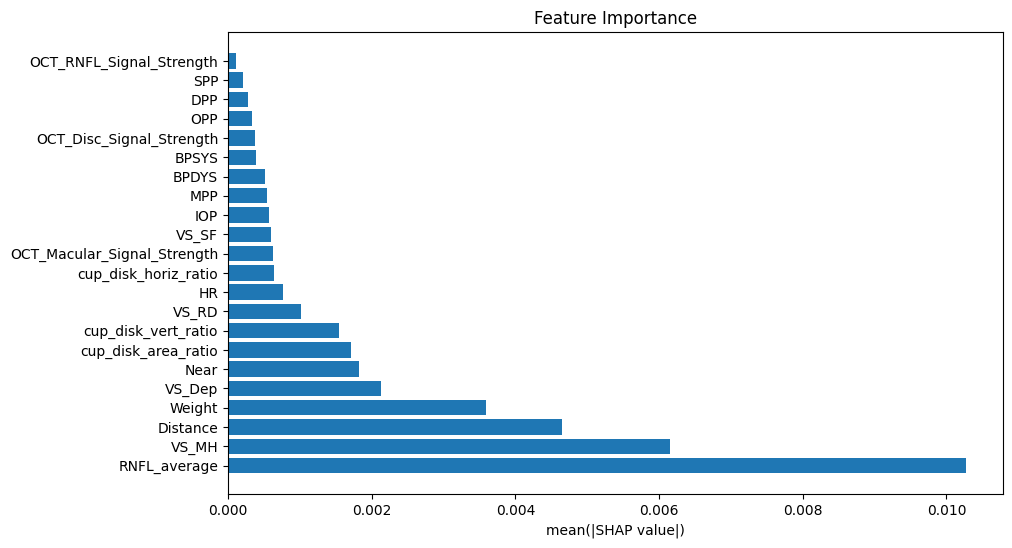

In [ ]:
test_size = 0.2

# Load and prepare data
data = pd.read_csv('/content/drive/MyDrive/Glaucoma_Project/Datasets/IGPS/maindata.csv')
data = data.dropna(subset=['cup_disk_area_ratio', 'cup_disk_vert_ratio', 'cup_disk_horiz_ratio', 'RNFL_average', 'IOP', 'BPSYS', 'BPDYS', 'SPP', 'DPP', 'OPP', 'MPP',
            'HR', 'Weight', 'Near', 'Distance', 'VS_SF', 'VS_MH', 'VS_RD', 'VS_Dep',
            'OCT_Disc_Signal_Strength', 'OCT_RNFL_Signal_Strength', 'OCT_Macular_Signal_Strength', 'MD'])

def assign_class_label(value):
    if value >= 0:
        return 0
    elif -0.01 >= value >= -5.00:
        return 1
    elif -5.01 >= value >= -12.00:
        return 2
    elif -12.01 >= value >= -20.00:
        return 3
    else:
        return 4

data['class_label'] = data['MD'].apply(assign_class_label)

features = ['cup_disk_area_ratio', 'cup_disk_vert_ratio', 'cup_disk_horiz_ratio', 'RNFL_average', 'IOP', 'BPSYS', 'BPDYS', 'SPP', 'DPP', 'OPP', 'MPP',
            'HR', 'Weight', 'Near', 'Distance', 'VS_SF', 'VS_MH', 'VS_RD', 'VS_Dep',
            'OCT_Disc_Signal_Strength', 'OCT_RNFL_Signal_Strength', 'OCT_Macular_Signal_Strength']
X = data[features]
y = data['class_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Train XGBoost model
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# SHAP implementation
def shap_values(model, X):
    # Get feature importances
    importances = model.feature_importances_

    # Calculate expected value (average prediction)
    expected_value = model.predict_proba(X).mean(axis=0)

    # Calculate SHAP values
    shap_values = []
    for i in range(X.shape[0]):
        row = X.iloc[i]
        shap_row = []
        for j, col in enumerate(X.columns):
            # Create copies of the row with and without the feature
            row_with = row.copy()
            row_without = row.copy()
            row_without[col] = 0

            # Calculate the difference in predictions
            pred_with = model.predict_proba(row_with.to_frame().T)[0]
            pred_without = model.predict_proba(row_without.to_frame().T)[0]

            # SHAP value is the difference weighted by feature importance
            shap_value = (pred_with - pred_without) * importances[j]
            shap_row.append(shap_value)
        shap_values.append(shap_row)

    return np.array(shap_values), expected_value

# Calculate SHAP values
shap_vals, expected_val = shap_values(model, X_test)

# Function to plot SHAP summary
def plot_shap_summary(shap_vals, feature_names):
    # Calculate mean absolute SHAP values for each feature
    mean_shap = np.abs(shap_vals).mean(axis=0)

    # If shap_vals is 3D (samples, features, classes), take mean over classes
    if mean_shap.ndim > 1:
        mean_shap = mean_shap.mean(axis=1)

    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': mean_shap})
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('mean(|SHAP value|)')
    plt.title('Feature Importance')
    plt.show()

# Plot SHAP summary
plot_shap_summary(shap_vals, features)

<ipython-input-56-c103f5b0e7af>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class_label'] = data['MD'].apply(assign_class_label)


Total Samples: 140
Samples per class: 35
Class distribution:
class_label
0    35
1    35
2    35
3    35
Name: count, dtype: int64


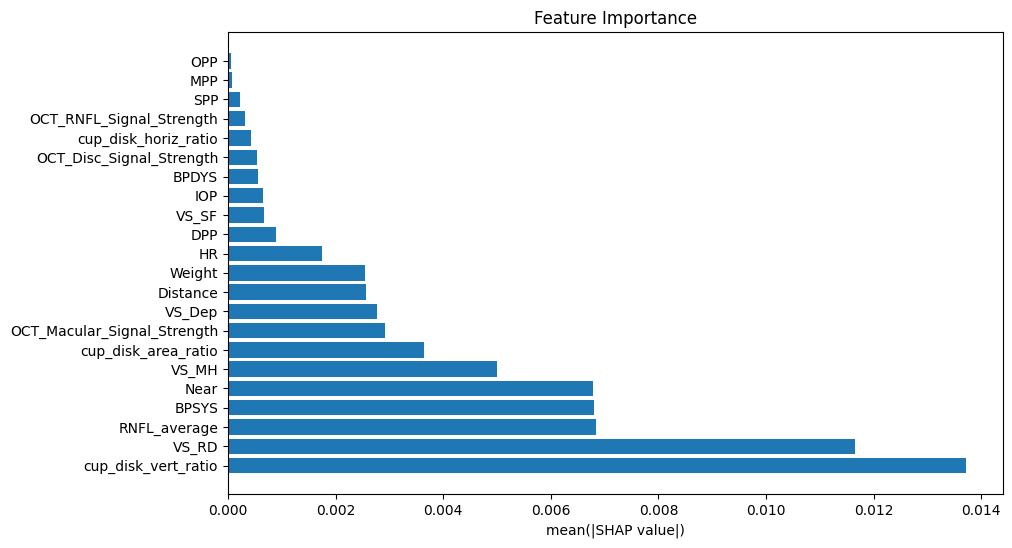

In [ ]:
test_size = 0.2
samples_per_class = 35  # number of samples to select from each class

# Load data from CSV
data = pd.read_csv('/content/drive/MyDrive/Glaucoma_Project/Datasets/IGPS/maindata.csv')

# Remove any rows with blank values from the columns of these datasets
data = pd.read_csv('/content/drive/MyDrive/Glaucoma_Project/Datasets/IGPS/maindata.csv')
data = data.dropna(subset=['cup_disk_area_ratio', 'cup_disk_vert_ratio', 'cup_disk_horiz_ratio', 'RNFL_average', 'IOP', 'BPSYS', 'BPDYS', 'SPP', 'DPP', 'OPP', 'MPP',
            'HR', 'Weight', 'Near', 'Distance', 'VS_SF', 'VS_MH', 'VS_RD', 'VS_Dep',
            'OCT_Disc_Signal_Strength', 'OCT_RNFL_Signal_Strength', 'OCT_Macular_Signal_Strength', 'MD'])

def assign_class_label(value):
    if value >= 0:
        return 0
    elif -0.01 >= value >= -5.00:
        return 1
    elif -5.01 >= value >= -12.00:
        return 2
    else:
        return 3

data['class_label'] = data['MD'].apply(assign_class_label)

features = ['cup_disk_area_ratio', 'cup_disk_vert_ratio', 'cup_disk_horiz_ratio', 'RNFL_average', 'IOP', 'BPSYS', 'BPDYS', 'SPP', 'DPP', 'OPP', 'MPP',
            'HR', 'Weight', 'Near', 'Distance', 'VS_SF', 'VS_MH', 'VS_RD', 'VS_Dep',
            'OCT_Disc_Signal_Strength', 'OCT_RNFL_Signal_Strength', 'OCT_Macular_Signal_Strength']

# Function to create a balanced dataset without repetition
def create_balanced_dataset(data, features, target, samples_per_class):
    balanced_data = []
    for class_label in data[target].unique():
        class_data = data[data[target] == class_label]
        if len(class_data) >= samples_per_class:
            balanced_data.append(class_data.sample(samples_per_class, random_state=42))
        else:
            print(f"Warning: Class {class_label} has only {len(class_data)} samples. Using all available samples.")
            balanced_data.append(class_data)

    return pd.concat(balanced_data, ignore_index=True)

# Create balanced dataset
balanced_data = create_balanced_dataset(data, features, 'class_label', samples_per_class)

X = balanced_data[features]
y = balanced_data['class_label']

# Print the number of total samples
print("Total Samples:", len(X))
print("Samples per class:", samples_per_class)
print("Class distribution:")
print(y.value_counts().sort_index())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Train XGBoost model
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# SHAP implementation
def shap_values(model, X):
    # Get feature importances
    importances = model.feature_importances_

    # Calculate expected value (average prediction)
    expected_value = model.predict_proba(X).mean(axis=0)

    # Calculate SHAP values
    shap_values = []
    for i in range(X.shape[0]):
        row = X.iloc[i]
        shap_row = []
        for j, col in enumerate(X.columns):
            # Create copies of the row with and without the feature
            row_with = row.copy()
            row_without = row.copy()
            row_without[col] = 0

            # Calculate the difference in predictions
            pred_with = model.predict_proba(row_with.to_frame().T)[0]
            pred_without = model.predict_proba(row_without.to_frame().T)[0]

            # SHAP value is the difference weighted by feature importance
            shap_value = (pred_with - pred_without) * importances[j]
            shap_row.append(shap_value)
        shap_values.append(shap_row)

    return np.array(shap_values), expected_value

# Calculate SHAP values
shap_vals, expected_val = shap_values(model, X_test)

# Function to plot SHAP summary
def plot_shap_summary(shap_vals, feature_names):
    # Calculate mean absolute SHAP values for each feature
    mean_shap = np.abs(shap_vals).mean(axis=0)

    # If shap_vals is 3D (samples, features, classes), take mean over classes
    if mean_shap.ndim > 1:
        mean_shap = mean_shap.mean(axis=1)

    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': mean_shap})
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('mean(|SHAP value|)')
    plt.title('Feature Importance')
    plt.show()

# Plot SHAP summary
plot_shap_summary(shap_vals, features)

Most Important Features - Uneven

In [ ]:
num_trials = 10 #number of times to run the model
train_size = 0.8 #the amount of the dataset used for training

# Load data from CSV
# maindata.csv needs to be in personal drive or have a shortcut added to the personal drive to be able to read it
data = pd.read_csv('/content/drive/MyDrive/Glaucoma_Project/Datasets/IGPS/maindata.csv')
data = data.dropna(subset=['cup_disk_vert_ratio', 'VS_RD', 'RNFL_average', 'MD'])

# Assign class labels based on the specified thresholds
def assign_class_label(value):
    if value >= 0:
        return 0
    elif -0.01 >= value >= -5.00:
        return 1
    elif -5.01 >= value >= -12.00:
        return 2
    elif -12.01 >= value >= -20.00:
        return 3
    else:
        return 4

# Create a new column to store the class labels based on the MD values
data['class_label'] = data['MD'].apply(assign_class_label)

# Select features and target
features = ['cup_disk_vert_ratio', 'VS_RD', 'RNFL_average']
X = data[features]
y = data['class_label']

# Print the number of total samples and samples in each class
print("Total Samples:", len(X))
print("\nSamples in each class:")
class_counts = y.value_counts().sort_index()
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples ({count/len(y)*100:.2f}%)")

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 50)
        self.layer2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        return self.layer2(x)

# Initialize lists to store results
accuracies = []

for trial in range(num_trials):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42+trial)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)

    # Use PyTorch model for feature extraction
    model = SimpleNN(input_size=len(features))
    train_features = model(X_train_tensor).detach().numpy()
    test_features = model(X_test_tensor).detach().numpy()

    # Train XGBoost model
    clf = XGBClassifier(random_state=42+trial)
    clf.fit(train_features, y_train)

    # Make predictions
    y_pred = clf.predict(test_features)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) * 100  # Convert to percentage
    accuracies.append(accuracy)

    print(f"Trial {trial+1} Accuracy: {accuracy:.2f}%")

# Print overall results
print(f"\nMean Accuracy: {np.mean(accuracies):.2f}%")
print(f"Standard Deviation: {np.std(accuracies):.2f}%")

# Print classification report for the last trial
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the number of training samples used in training
print("Total Samples:", len(X))
print(f"Training Samples: {len(X_train)} ({len(X_train)/len(X)*100:.2f}%)")
print(f"Testing Samples: {len(X_test)} ({len(X_test)/len(X)*100:.2f}%)")

Total Samples: 916

Samples in each class:
Class 0: 160 samples (17.47%)
Class 1: 513 samples (56.00%)
Class 2: 197 samples (21.51%)
Class 3: 38 samples (4.15%)
Class 4: 8 samples (0.87%)
Trial 1 Accuracy: 63.59%
Trial 2 Accuracy: 60.33%
Trial 3 Accuracy: 59.24%
Trial 4 Accuracy: 60.33%
Trial 5 Accuracy: 57.61%
Trial 6 Accuracy: 59.24%
Trial 7 Accuracy: 59.78%
Trial 8 Accuracy: 55.98%
Trial 9 Accuracy: 62.50%
Trial 10 Accuracy: 60.87%

Mean Accuracy: 59.95%
Standard Deviation: 2.08%

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.26      0.28        31
           1       0.67      0.81      0.73       111
           2       0.47      0.23      0.31        30
           3       0.71      0.50      0.59        10
           4       1.00      1.00      1.00         2

    accuracy                           0.61       184
   macro avg       0.63      0.56      0.58       184
weighted avg       0.58      0.61      0.58       184


In [ ]:
num_trials = 10 #number of times to run the model
train_size = 0.8 #the amount of the dataset used for training

# Load data from CSV
# maindata.csv needs to be in personal drive or have a shortcut added to the personal drive to be able to read it
data = pd.read_csv('/content/drive/MyDrive/Glaucoma_Project/Datasets/IGPS/maindata.csv')
data = data.dropna(subset=['Distance', 'VS_MH', 'RNFL_average', 'MD'])

# Assign class labels based on the specified thresholds
def assign_class_label(value):
    if value >= 0:
        return 0
    elif -0.01 >= value >= -5.00:
        return 1
    elif -5.01 >= value >= -12.00:
        return 2
    elif -12.01 >= value >= -20.00:
        return 3
    else:
        return 4

# Create a new column to store the class labels based on the MD values
data['class_label'] = data['MD'].apply(assign_class_label)

# Select features and target
features = ['Distance', 'VS_MH', 'RNFL_average']
X = data[features]
y = data['class_label']

# Print the number of total samples and samples in each class
print("Total Samples:", len(X))
print("\nSamples in each class:")
class_counts = y.value_counts().sort_index()
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples ({count/len(y)*100:.2f}%)")

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 50)
        self.layer2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        return self.layer2(x)

# Initialize lists to store results
accuracies = []

for trial in range(num_trials):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42+trial)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)

    # Use PyTorch model for feature extraction
    model = SimpleNN(input_size=len(features))
    train_features = model(X_train_tensor).detach().numpy()
    test_features = model(X_test_tensor).detach().numpy()

    # Train XGBoost model
    clf = XGBClassifier(random_state=42+trial)
    clf.fit(train_features, y_train)

    # Make predictions
    y_pred = clf.predict(test_features)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) * 100  # Convert to percentage
    accuracies.append(accuracy)

    print(f"Trial {trial+1} Accuracy: {accuracy:.2f}%")

# Print overall results
print(f"\nMean Accuracy: {np.mean(accuracies):.2f}%")
print(f"Standard Deviation: {np.std(accuracies):.2f}%")

# Print classification report for the last trial
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the number of training samples used in training
print("Total Samples:", len(X))
print(f"Training Samples: {len(X_train)} ({len(X_train)/len(X)*100:.2f}%)")
print(f"Testing Samples: {len(X_test)} ({len(X_test)/len(X)*100:.2f}%)")

Total Samples: 901

Samples in each class:
Class 0: 159 samples (17.65%)
Class 1: 496 samples (55.05%)
Class 2: 200 samples (22.20%)
Class 3: 38 samples (4.22%)
Class 4: 8 samples (0.89%)
Trial 1 Accuracy: 70.17%
Trial 2 Accuracy: 72.38%
Trial 3 Accuracy: 72.38%
Trial 4 Accuracy: 75.14%
Trial 5 Accuracy: 69.61%
Trial 6 Accuracy: 74.03%
Trial 7 Accuracy: 67.96%
Trial 8 Accuracy: 62.98%
Trial 9 Accuracy: 69.06%
Trial 10 Accuracy: 69.61%

Mean Accuracy: 70.33%
Standard Deviation: 3.28%

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.44      0.52        36
           1       0.74      0.81      0.77       101
           2       0.62      0.71      0.66        34
           3       0.67      0.25      0.36         8
           4       1.00      1.00      1.00         2

    accuracy                           0.70       181
   macro avg       0.73      0.64      0.66       181
weighted avg       0.69      0.70      0.68       181


Most Important Features - Even

In [ ]:
num_trials = 10  # number of times to run the model
train_size = 0.8  # the amount of the dataset used for training
samples_per_class = 35  # number of samples to select from each class

# Load data from CSV
data = pd.read_csv('/content/drive/MyDrive/Glaucoma_Project/Datasets/IGPS/maindata.csv')

# Remove any rows with blank values from the columns of these datasets
data = data.dropna(subset=['cup_disk_vert_ratio', 'VS_RD', 'RNFL_average','MD'])

# Assign class labels based on the specified thresholds
def assign_class_label(value):
    if value >= 0:
        return 0
    elif -5.00 <= value < -0.01:
        return 1
    elif -12.00 <= value < -5.01:
        return 2
    else:
        return 3

# Create a new column to store the class labels based on the MD values
data['class_label'] = data['MD'].apply(assign_class_label)

# Select features and target
features = ['cup_disk_vert_ratio', 'VS_RD', 'RNFL_average']

# Function to create a balanced dataset without repetition
def create_balanced_dataset(data, features, target, samples_per_class):
    balanced_data = []
    for class_label in data[target].unique():
        class_data = data[data[target] == class_label]
        if len(class_data) >= samples_per_class:
            balanced_data.append(class_data.sample(samples_per_class, random_state=42))
        else:
            print(f"Warning: Class {class_label} has only {len(class_data)} samples. Using all available samples.")
            balanced_data.append(class_data)

    return pd.concat(balanced_data, ignore_index=True)

# Create balanced dataset
balanced_data = create_balanced_dataset(data, features, 'class_label', samples_per_class)

X = balanced_data[features]
y = balanced_data['class_label']

# Print the number of total samples
print("Total Samples:", len(X))
print("Samples per class:", samples_per_class)
print("Class distribution:")
print(y.value_counts().sort_index())

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 50)
        self.layer2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        return self.layer2(x)

# Initialize lists to store results
accuracies = []

for trial in range(num_trials):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, stratify=y, random_state=42+trial)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)

    # Use PyTorch model for feature extraction
    model = SimpleNN(input_size=len(features))
    train_features = model(X_train_tensor).detach().numpy()
    test_features = model(X_test_tensor).detach().numpy()

    # Train XGBoost model
    clf = XGBClassifier(random_state=42+trial)
    clf.fit(train_features, y_train)

    # Make predictions
    y_pred = clf.predict(test_features)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) * 100  # Convert to percentage
    accuracies.append(accuracy)

    print(f"Trial {trial+1} Accuracy: {accuracy:.2f}%")

    # Print the number of samples of each class in the testing set
    # print("Number of samples in each class (Testing Set):")
    # test_class_counts = y_test.value_counts().sort_index()
    # for class_label, count in test_class_counts.items():
    #     print(f"Class {class_label}: {count} samples")
    # print()

# Print overall results
print(f"\nMean Accuracy: {np.mean(accuracies):.2f}%")
print(f"Standard Deviation: {np.std(accuracies):.2f}%")

# Print classification report for the last trial
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the number of training samples used in training
print("Total Samples:", len(X))
print(f"Training Samples: {len(X_train)} ({len(X_train)/len(X)*100:.2f}%)")
print(f"Testing Samples: {len(X_test)} ({len(X_test)/len(X)*100:.2f}%)")

Total Samples: 140
Samples per class: 35
Class distribution:
class_label
0    35
1    35
2    35
3    35
Name: count, dtype: int64
Trial 1 Accuracy: 67.86%
Trial 2 Accuracy: 42.86%
Trial 3 Accuracy: 39.29%
Trial 4 Accuracy: 50.00%
Trial 5 Accuracy: 60.71%
Trial 6 Accuracy: 67.86%
Trial 7 Accuracy: 50.00%
Trial 8 Accuracy: 57.14%
Trial 9 Accuracy: 64.29%
Trial 10 Accuracy: 46.43%

Mean Accuracy: 54.64%
Standard Deviation: 9.85%

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.71      0.62         7
           1       0.20      0.14      0.17         7
           2       0.50      0.29      0.36         7
           3       0.50      0.71      0.59         7

    accuracy                           0.46        28
   macro avg       0.44      0.46      0.44        28
weighted avg       0.44      0.46      0.44        28

Total Samples: 140
Training Samples: 112 (80.00%)
Testing Samples: 28 (20.00%)


In [ ]:
num_trials = 10  # number of times to run the model
train_size = 0.8  # the amount of the dataset used for training
samples_per_class = 35  # number of samples to select from each class

# Load data from CSV
data = pd.read_csv('/content/drive/MyDrive/Glaucoma_Project/Datasets/IGPS/maindata.csv')

# Remove any rows with blank values from the columns of these datasets
data = data.dropna(subset=['Distance', 'VS_MH', 'RNFL_average','MD'])

# Assign class labels based on the specified thresholds
def assign_class_label(value):
    if value >= 0:
        return 0
    elif -5.00 <= value < -0.01:
        return 1
    elif -12.00 <= value < -5.01:
        return 2
    else:
        return 3

# Create a new column to store the class labels based on the MD values
data['class_label'] = data['MD'].apply(assign_class_label)

# Select features and target
features = ['Distance', 'VS_MH', 'RNFL_average']

# Function to create a balanced dataset without repetition
def create_balanced_dataset(data, features, target, samples_per_class):
    balanced_data = []
    for class_label in data[target].unique():
        class_data = data[data[target] == class_label]
        if len(class_data) >= samples_per_class:
            balanced_data.append(class_data.sample(samples_per_class, random_state=42))
        else:
            print(f"Warning: Class {class_label} has only {len(class_data)} samples. Using all available samples.")
            balanced_data.append(class_data)

    return pd.concat(balanced_data, ignore_index=True)

# Create balanced dataset
balanced_data = create_balanced_dataset(data, features, 'class_label', samples_per_class)

X = balanced_data[features]
y = balanced_data['class_label']

# Print the number of total samples
print("Total Samples:", len(X))
print("Samples per class:", samples_per_class)
print("Class distribution:")
print(y.value_counts().sort_index())

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 50)
        self.layer2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        return self.layer2(x)

# Initialize lists to store results
accuracies = []

for trial in range(num_trials):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, stratify=y, random_state=42+trial)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)

    # Use PyTorch model for feature extraction
    model = SimpleNN(input_size=len(features))
    train_features = model(X_train_tensor).detach().numpy()
    test_features = model(X_test_tensor).detach().numpy()

    # Train XGBoost model
    clf = XGBClassifier(random_state=42+trial)
    clf.fit(train_features, y_train)

    # Make predictions
    y_pred = clf.predict(test_features)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) * 100  # Convert to percentage
    accuracies.append(accuracy)

    print(f"Trial {trial+1} Accuracy: {accuracy:.2f}%")

    # Print the number of samples of each class in the testing set
    # print("Number of samples in each class (Testing Set):")
    # test_class_counts = y_test.value_counts().sort_index()
    # for class_label, count in test_class_counts.items():
    #     print(f"Class {class_label}: {count} samples")
    # print()

# Print overall results
print(f"\nMean Accuracy: {np.mean(accuracies):.2f}%")
print(f"Standard Deviation: {np.std(accuracies):.2f}%")

# Print classification report for the last trial
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the number of training samples used in training
print("Total Samples:", len(X))
print(f"Training Samples: {len(X_train)} ({len(X_train)/len(X)*100:.2f}%)")
print(f"Testing Samples: {len(X_test)} ({len(X_test)/len(X)*100:.2f}%)")

Total Samples: 140
Samples per class: 35
Class distribution:
class_label
0    35
1    35
2    35
3    35
Name: count, dtype: int64
Trial 1 Accuracy: 64.29%
Trial 2 Accuracy: 75.00%
Trial 3 Accuracy: 64.29%
Trial 4 Accuracy: 53.57%
Trial 5 Accuracy: 50.00%
Trial 6 Accuracy: 67.86%
Trial 7 Accuracy: 64.29%
Trial 8 Accuracy: 60.71%
Trial 9 Accuracy: 53.57%
Trial 10 Accuracy: 57.14%

Mean Accuracy: 61.07%
Standard Deviation: 7.22%

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.25      0.14      0.18         7
           2       0.45      0.71      0.56         7
           3       0.80      0.57      0.67         7

    accuracy                           0.57        28
   macro avg       0.56      0.57      0.55        28
weighted avg       0.56      0.57      0.55        28

Total Samples: 140
Training Samples: 112 (80.00%)
Testing Samples: 28 (20.00%)
